In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

## Load the Dataset

To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


Build the model and fit

In [3]:
def build_fit(x_train=None, x_train_noisy=None, x_test=None, x_test_noisy= None, autoencoder=None, denoising=False):
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  if denoising == True:
    autoencoder.fit(x_train_noisy, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test))
  else:
      autoencoder.fit(x_train, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test, x_test))


Display encoding and decoding images

In [4]:
def plot(original, decoded_imgs):
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [5]:
latent_dim = 64

## Basic Autoencoder

Define an autoencoder with two Dense layers: an encoder, which compresses the images into a 64 dimensional latent vector, and a decoder, that reconstructs the original image from the latent space.

In [6]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    #784 is the dim of the image, 28*28pixels
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [7]:
autoencoder = Autoencoder(latent_dim)
build_fit(x_train=x_train, x_test=x_test, autoencoder=autoencoder)

Epoch 1/10
1875/1875 [==============================] - 13s 5ms/step - loss: 0.0237 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.00

In [8]:

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(decoded_imgs=decoded_imgs)

TypeError: ignored

## Sparse Autoencoder

In [ ]:
from keras import regularizers

class SparseAutoencoder(Model):
  # add regularizer to dense layer
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activity_regularizer=regularizers.l1(10e-5),
                   activation='relu'),
    ])
    #784 is the dim of the image, 28*28pixels
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder = SparseAutoencoder(latent_dim)
build_fit(x_train=x_train, x_test=x_test, autoencoder=autoencoder)

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(decoded_imgs=decoded_imgs)

## Denoising Autoencoders

An autoencoder can also be trained to remove noise from images.

In [ ]:
# add random noise to images and plot it

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [ ]:
# we can re-use the basic autoencoder changing training dataset with noisy images
autonecoder = Autoencoder(latent_dim)
build_fit(x_train=x_train, x_train_noisy=x_train_noisy,
          x_test=x_test, x_test_noisy=x_test_noisy, autoencoder=autoencoder, denoising=True)

In [ ]:
#plot
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(original=x_test_noisy, decoded_imgs=decoded_imgs)

In [ ]:
# or we can use a convolutional model
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autonecoder = Denoise()
build_fit(x_train=x_train, x_train_noisy=x_train_noisy,
          x_test=x_test, x_test_noisy=x_test_noisy, autoencoder=autoencoder, denoising=True)

In [ ]:
#plot
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(original=x_test_noisy, decoded_imgs=decoded_imgs)

## Contractive Autoencoders

In [ ]:
#to do, define custom loss and use basic autoencoder
lambda_reg = 0.00001
def ContractiveLoss(y_true, y_pred):
  mse = losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
  mean_squared_error = mse(y_true, y_pred)
  forbenius = tf.sqrt(tf.reduce_sum(tf.square(y_pred)))
  return mean_squared_error + (lambda_reg*forbenius)  

In [ ]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=ContractiveLoss)
autoencoder.fit(x_train, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test, x_test))

In [ ]:
#plot
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot(original=x_test, decoded_imgs=decoded_imgs)

## Variational Autoencoder

it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

In [9]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

In [10]:
from keras import backend as K

#sample new similar points from latent space
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon


def VariationalAutoencoder():
  inputs = tf.keras.Input(shape=(original_dim,))
  h = layers.Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = layers.Dense(latent_dim)(h)
  z_log_sigma = layers.Dense(latent_dim)(h)

  z = layers.Lambda(sampling)([z_mean, z_log_sigma])

  # Create encoder
  encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

  # Create decoder
  latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
  x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = layers.Dense(original_dim, activation='sigmoid')(x)
  decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

  # instantiate VAE model
  outputs = decoder(encoder(inputs)[2])
  vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

  # We train the model using the end-to-end model, with a custom loss function: 
  # the sum of a reconstruction term, and the KL divergence regularization term.
  reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
  reconstruction_loss *= original_dim
  kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')

  return vae, encoder, decoder

In [11]:
vae, encoder, decoder = VariationalAutoencoder()

In [12]:
#train on mnist digit

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32,
        validation_data=(x_test, x_test))

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 185.2502 - val_loss: 167.2957
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 165.1516 - val_loss: 163.6159
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 161.9505 - val_loss: 161.2126
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 159.7834 - val_loss: 159.2331
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 158.0401 - val_loss: 157.3887
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 156.5102 - val_loss: 156.0281
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 155.2923 - val_loss: 155.0183
Epoch 8/50
1875/1875 [==============================] - 5s 3ms/step - loss: 154.3133 - val_loss: 154.2240
Epoch 9/50
1875/1875 [==============================] - 5s 3ms/step - loss: 153.5618 -

In [13]:
# look at the neighborhoods of different classes on the latent 2D plane

x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

TypeError: ignored

<Figure size 432x432 with 0 Axes>

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

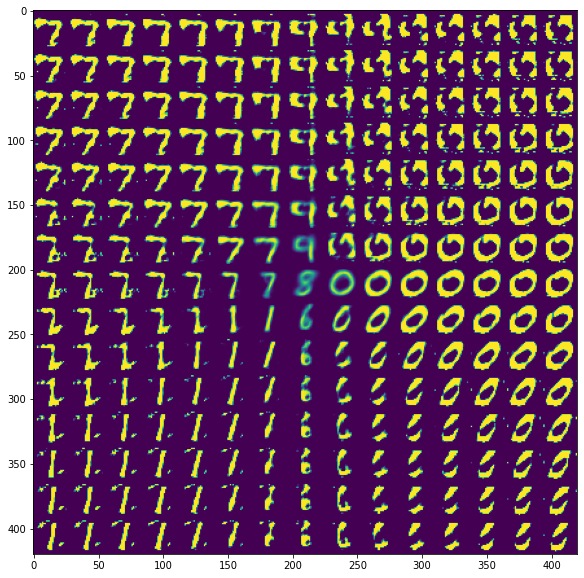

In [14]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()